# Домашнее задание

### Д/з из четырех пунктов:
* Улучшение `fit_generator`
* Сравнение двух ReLU (разные активации)
* Испорченный батч-норм 
* "Сырые" данные. 

### Что нужно сделать
* Следовать инструкциям в каждом из пунктов.
* Результатами вашей работы будет ноутбук с доработанным кодом + архив с директорией с логами `tensorboard` `logs/`, в который вы запишите результаты экспериментов. Подробности в инструкциях ниже.
* Можно и нужно пользоваться кодом из файла `utils`, **но** весь код модифицируйте, пожалуйста, в ноутбуках! Так мне будет проще проверять.

**Загрузка tensorboard в ноутбук**

Можете попробовать использовать его так на свой страх и риск :)

In [1]:
#запуск TensorBoard из командной строки
# %load_ext tensorboard
# %tensorboard --logdir logs

**Импорты**

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from typing import Callable

### Импорт слоев для д/з

In [2]:
from utils import BatchNormFlawed, Dense, DenseSmart, Sequential, MNISTSequence

### Загрузка данных

> Здесь ничего менять не нужно

In [3]:
(X_tr, y_tr), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [4]:
train_seq = MNISTSequence(X_tr, y_tr, 128)
test_seq = MNISTSequence(X_test, y_test, 128)

**Очистка данных**

In [5]:
!rm -rf logs/*

In [6]:
!mkdir -p logs

In [7]:
keras.backend.clear_session()

## 1. Улучшение fit_generator

Улучшите метод `fit_generator` так, чтобы он:
* Записывал значения градиентов для всех переменных при помощи `tf.summary.histogram` 
* Записывал значения ошибки и метрики на валидации с помощью `tf.summary.scalar`

Затем сделайте monkey patch класса sequential обновленным методом (следующая ячейка за методом `fit_generator`).

In [8]:
def fit_generator(self, train_seq, eval_seq, epoch, loss, optimizer, writer=None):
    history = dict(train=list(), val=list())

    train_loss_results = list()
    val_loss_results = list()

    train_accuracy_results = list()
    val_accuracy_results = list()

    step = 0
    for e in range(epoch):
        p = tf.keras.metrics.Mean()
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_loss_avg_val = tf.keras.metrics.Mean()

        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        epoch_accuracy_val = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in train_seq:
            with tf.GradientTape() as tape:
                if step % 50 == 0:
                    prediction = self._forward(x, writer, step)
                else:
                    prediction = self._forward(x)
                loss_value = loss(y, prediction)
            
            gradients = tape.gradient(loss_value, self._trainable_variables)
            
            if step % 50 == 0:
                grad_names = list()
                for layer in self._layers:
                    for var_num, var in enumerate(layer.get_trainable()):
                        grad_names.append(f"grad_{layer.name}_{var_num}")

                if writer is not None:  #added
                    with writer.as_default():  #added
                        for g, g_name in zip(gradients, grad_names):  #added
                            tf.summary.histogram(g_name, g, step=step)  #added
                
                
            
            optimizer.apply_gradients(zip(gradients, self._trainable_variables))
            epoch_accuracy.update_state(y, prediction)
            epoch_loss_avg.update_state(loss_value)

            if step % 50 == 0:
                with writer.as_default():
                    tf.summary.scalar('train_accuracy', epoch_accuracy.result().numpy(), step=step)
                    tf.summary.scalar('train_loss', epoch_loss_avg.result().numpy(), step=step)

            step += 1

        train_accuracy_results.append(epoch_accuracy.result().numpy())
        train_loss_results.append(epoch_loss_avg.result().numpy())

        for x, y in eval_seq:
            prediction = self._forward(x)
            loss_value = loss(y, prediction)
            epoch_loss_avg_val.update_state(loss_value)
            epoch_accuracy_val.update_state(y, prediction)
        
        if writer is not None:
            with writer.as_default():  #added
                tf.summary.scalar('eval_accuracy', epoch_accuracy_val.result().numpy(), step=e * len(train_seq))  #added
                tf.summary.scalar('eval_loss', epoch_loss_avg_val.result().numpy(), step=e * len(train_seq))  #added
            
        val_accuracy_results.append(epoch_accuracy_val.result().numpy())
        val_loss_results.append(epoch_loss_avg_val.result().numpy())

        print("Epoch {}: Train loss: {:.3f} Train Accuracy: {:.3f}".format(e + 1,
                                                                           train_loss_results[-1],
                                                                           train_accuracy_results[-1]))
        print("Epoch {}: Val loss: {:.3f} Val Accuracy: {:.3f}".format(e + 1,
                                                                       val_loss_results[-1],
                                                                       val_accuracy_results[-1]))
        print('*' * 20)

    return None

In [9]:
# Monkey patch: обновляем метод
Sequential.fit_generator = fit_generator

## 2. Сравнение двух ReLU (разные активации)

Запустите два эксперимента ниже. Сравните результаты - значения метрик после каждого из них.

Запустите tensorboard, изучите распределения активаций, градиентов и т.д. для `relu` и `smart_dense_relu`. 

Подумайте, почему в одном случае сеть обучается плохо, а в другом - хорошо. Вставьте в ноутбук (или напишите список названий) тех графики из tensorboard, которые, по вашему мнению, это иллюстрируют, и напишите, почему.


Команда для запуска tensorboard в bash:

`$ tensorboard --logdir logs/`

**Ваш комментарий:**



---------




* `relu_smart_dense` достигает accuracy=1 быстрее `relu`; `relu` вообще не достигает 1, а выходит на плато~0.65.
* Также `relu_smart_dense` изначально принимает loss, меньший, чем у `relu`. Далее скорость ументшения loss у `relu_smart_dense` выше и приходит к 0 быстрее, при том, что `relu` имеет наилучший loss равный только лишь 5.5.

In [10]:
writer = tf.summary.create_file_writer("logs/relu")

model = Sequential(Dense(784, 100, tf.nn.relu, 'dense'), 
                   Dense(100, 100, tf.nn.relu, 'dense1'), 
                   Dense(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 11.632 Train Accuracy: 0.275
Epoch 1: Val loss: 8.815 Val Accuracy: 0.449
********************
Epoch 2: Train loss: 8.316 Train Accuracy: 0.480
Epoch 2: Val loss: 7.347 Val Accuracy: 0.540
********************
Epoch 3: Train loss: 7.329 Train Accuracy: 0.542
Epoch 3: Val loss: 6.789 Val Accuracy: 0.577
********************
Epoch 4: Train loss: 6.695 Train Accuracy: 0.582
Epoch 4: Val loss: 5.935 Val Accuracy: 0.629
********************
Epoch 5: Train loss: 5.215 Train Accuracy: 0.673
Epoch 5: Val loss: 4.579 Val Accuracy: 0.713
********************
Epoch 6: Train loss: 4.659 Train Accuracy: 0.708
Epoch 6: Val loss: 4.524 Val Accuracy: 0.717
********************
Epoch 7: Train loss: 4.500 Train Accuracy: 0.719
Epoch 7: Val loss: 4.329 Val Accuracy: 0.729
********************
Epoch 8: Train loss: 4.407 Train Accuracy: 0.725
Epoch 8: Val loss: 4.329 Val Accuracy: 0.730
********************
Epoch 9: Train loss: 4.332 Train Accuracy: 0.730
Epoch 9: Val loss: 4.219 Val A

In [11]:
writer = tf.summary.create_file_writer("logs/relu_smart_dense")

model = Sequential(DenseSmart(784, 100, tf.nn.relu, 'dense'), 
                   DenseSmart(100, 100, tf.nn.relu, 'dense1'), 
                   DenseSmart(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 0.327 Train Accuracy: 0.903
Epoch 1: Val loss: 0.207 Val Accuracy: 0.935
********************
Epoch 2: Train loss: 0.128 Train Accuracy: 0.962
Epoch 2: Val loss: 0.154 Val Accuracy: 0.951
********************
Epoch 3: Train loss: 0.089 Train Accuracy: 0.974
Epoch 3: Val loss: 0.138 Val Accuracy: 0.957
********************
Epoch 4: Train loss: 0.063 Train Accuracy: 0.982
Epoch 4: Val loss: 0.112 Val Accuracy: 0.967
********************
Epoch 5: Train loss: 0.049 Train Accuracy: 0.985
Epoch 5: Val loss: 0.099 Val Accuracy: 0.972
********************
Epoch 6: Train loss: 0.040 Train Accuracy: 0.988
Epoch 6: Val loss: 0.099 Val Accuracy: 0.972
********************
Epoch 7: Train loss: 0.033 Train Accuracy: 0.990
Epoch 7: Val loss: 0.105 Val Accuracy: 0.972
********************
Epoch 8: Train loss: 0.030 Train Accuracy: 0.990
Epoch 8: Val loss: 0.110 Val Accuracy: 0.972
********************
Epoch 9: Train loss: 0.030 Train Accuracy: 0.990
Epoch 9: Val loss: 0.111 Val Ac

## 3.a Испорченный батч-норм 

Запустите два эксперимент ниже. 

Почему обучение не идет? В чем ошибка в слое `BatchNorm`? Изучите и исправьте код метода `__call__` (Шаблон находится ниже под блоком с экспериментом.).

Можно пользоваться tensorboard, если он нужен.

## ReLU + Batch Norm

In [12]:
writer = tf.summary.create_file_writer("logs/relu_bn")

model = Sequential(Dense(784, 100, tf.nn.relu, 'dense'), 
                   BatchNormFlawed('batch_norm'), 
                   Dense(100, 100, tf.nn.relu, 'dense1'), 
                   Dense(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: nan Train Accuracy: 0.099
Epoch 1: Val loss: nan Val Accuracy: 0.098
********************
Epoch 2: Train loss: nan Train Accuracy: 0.099
Epoch 2: Val loss: nan Val Accuracy: 0.098
********************
Epoch 3: Train loss: nan Train Accuracy: 0.099
Epoch 3: Val loss: nan Val Accuracy: 0.098
********************
Epoch 4: Train loss: nan Train Accuracy: 0.099
Epoch 4: Val loss: nan Val Accuracy: 0.098
********************
Epoch 5: Train loss: nan Train Accuracy: 0.099
Epoch 5: Val loss: nan Val Accuracy: 0.098
********************
Epoch 6: Train loss: nan Train Accuracy: 0.099
Epoch 6: Val loss: nan Val Accuracy: 0.098
********************
Epoch 7: Train loss: nan Train Accuracy: 0.099
Epoch 7: Val loss: nan Val Accuracy: 0.098
********************
Epoch 8: Train loss: nan Train Accuracy: 0.099
Epoch 8: Val loss: nan Val Accuracy: 0.098
********************
Epoch 9: Train loss: nan Train Accuracy: 0.099
Epoch 9: Val loss: nan Val Accuracy: 0.098
********************
E

Действительно обучения не происходит - значения lossи accuracy остаются на 0.
<br><br>Для номрализации батча в статье
<br>Sergey Ioffe & Christian Szegedy: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift [https://arxiv.org/pdf/1502.03167v3.pdf]
<br>используют стандартную формулу для номрализации значения "минус среднее и поделить на корень из дисперсии", но поскольку дисперсия может в какой-то момент принять 0, то такая формула "ломается" и выдает `NaN`.
<br><br>Для предотвращения этого я воспользовалась добалением пренибрежимо малой величиной $\epsilon = 1e-8$ , значение которой взяла из статьи 
<br>[https://towardsdatascience.com/understanding-batch-normalization-with-examples-in-numpy-and-tensorflow-with-interactive-code-7f59bb126642]:
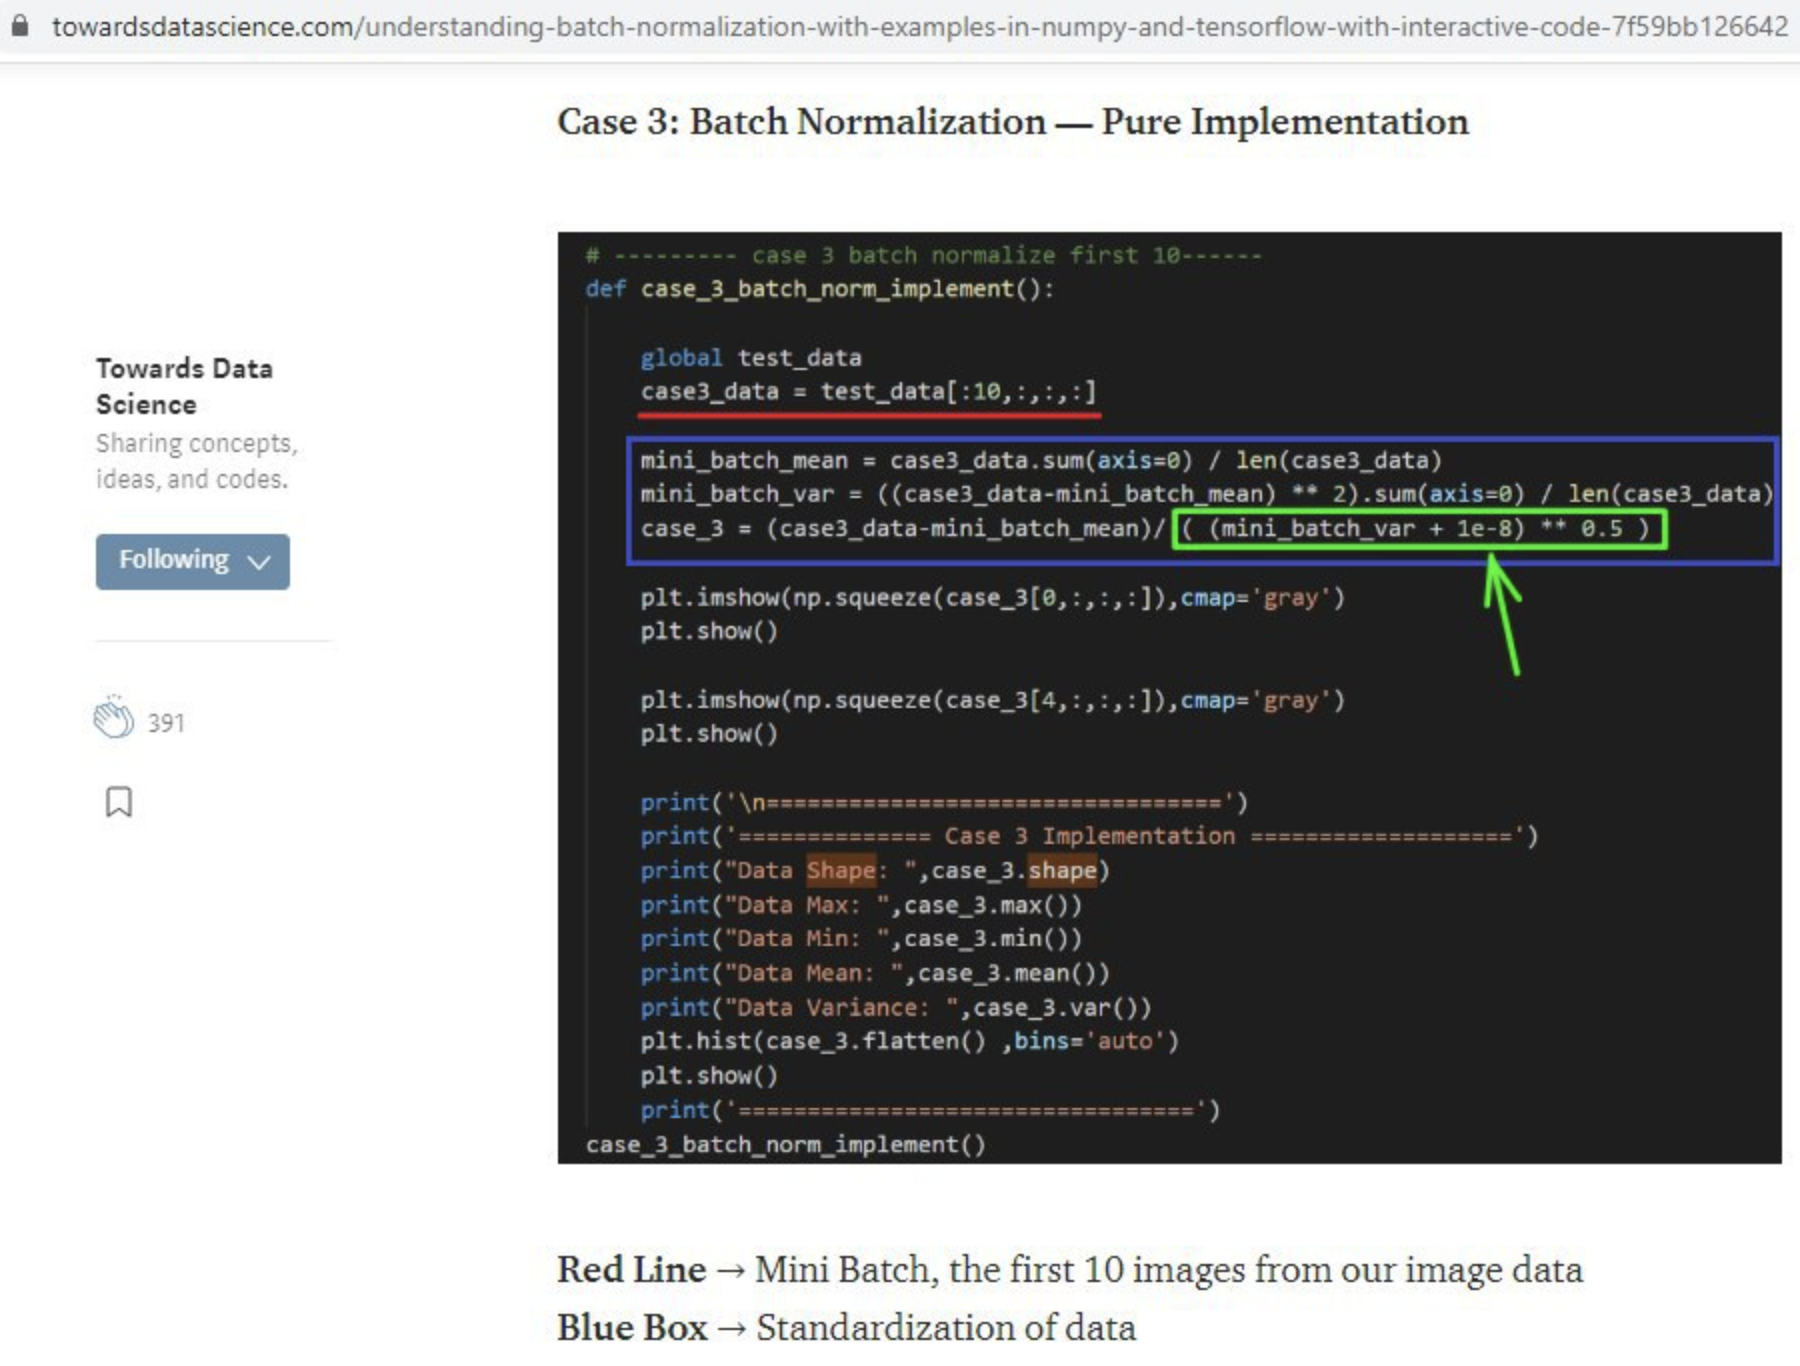
### Или можно воспользоваться tf.keras.backend.epsilon(), который возвращает 1e-7

**Класс, который нужно исправить**

In [13]:
class BatchNormFixed(BatchNormFlawed):
    def __call__(self, x, writer=None, step=None):
        mu = tf.reduce_mean(x, axis=0)
        sigma = tf.math.reduce_std(x, axis=0)
        normed = (x - mu) / (sigma**2 + keras.backend.epsilon())**0.5  #added
        out = normed * self._gamma + self._beta
        
        if writer is not None:
            with writer.as_default():
                tf.summary.histogram(self.name + '_beta', self._beta, step=step)
                tf.summary.histogram(self.name + '_gamma', self._gamma, step=step)
                tf.summary.histogram(self.name + '_normed', normed, step=step)
                tf.summary.histogram(self.name + '_out', out, step=step)
                tf.summary.histogram(self.name + '_sigma', sigma, step=step)
                tf.summary.histogram(self.name + '_mu', mu, step=step)
        return out

## 3.b Исправленный батч-норм 

Запустите эксперимент ниже. 

Обучается ли сеть? Идет ли процесс обучения лучше, чем в эксперименте с ReLU? 

Сравните обучение сетей c ReLU и слоем `Dense` (а не `DenseSmart`!) и ReLU с BatchNorm в tensorboard, как в задании 2.
Напишите ваши выводы.

_Обратите внимание, что слева в интерфейсе tensorboard есть меню, которое позволяет выключать визуализацию ненужных экспериментов._

**Ваш комментарий:**



---------


После добаления $\epsilon$ сеть начала учиться.
<br>В сравнении с `RelU+Dense` `ReLu+BatchNorm` обучается быстрее - уменьшает loss быстрее. А также использвоание BatchNorm позваоляет повысить финальное значение accuracy чуть ли не в 2 раза по сравнению просто с `ReLu`.

Значения bias (ошибки/шума) после слоя 2 для `ReLu+BatchNorm` становятся более распределенными/разрозненными, по сравнению с `ReLu`, где шум группироуется вокруг 0, искажая (добавляя большей погрешности) для значений z слоя.

Выходные значения после слоя 2 принимают форму пиков для `ReLu+BatchNorm`, по сравнению с `ReLu`.

In [14]:
writer = tf.summary.create_file_writer("logs/relu_bn_fixed")

model = Sequential(Dense(784, 100, tf.nn.relu, 'dense'), 
                   BatchNormFixed('batch_norm'), 
                   Dense(100, 100, tf.nn.relu, 'dense1'), 
                   Dense(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq, test_seq, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 9.116 Train Accuracy: 0.397
Epoch 1: Val loss: 5.020 Val Accuracy: 0.630
********************
Epoch 2: Train loss: 2.074 Train Accuracy: 0.727
Epoch 2: Val loss: 0.639 Val Accuracy: 0.812
********************
Epoch 3: Train loss: 0.605 Train Accuracy: 0.821
Epoch 3: Val loss: 0.509 Val Accuracy: 0.849
********************
Epoch 4: Train loss: 0.500 Train Accuracy: 0.850
Epoch 4: Val loss: 0.435 Val Accuracy: 0.869
********************
Epoch 5: Train loss: 0.430 Train Accuracy: 0.870
Epoch 5: Val loss: 0.384 Val Accuracy: 0.883
********************
Epoch 6: Train loss: 0.378 Train Accuracy: 0.885
Epoch 6: Val loss: 0.345 Val Accuracy: 0.895
********************
Epoch 7: Train loss: 0.337 Train Accuracy: 0.898
Epoch 7: Val loss: 0.314 Val Accuracy: 0.905
********************
Epoch 8: Train loss: 0.302 Train Accuracy: 0.909
Epoch 8: Val loss: 0.288 Val Accuracy: 0.912
********************
Epoch 9: Train loss: 0.272 Train Accuracy: 0.918
Epoch 9: Val loss: 0.267 Val Ac

## 4. "Сырые" данные. 

Что будет, если заставить сеть обучаться на сырых данных? 

Напишите такую функцию `preprocess`, которая не делает min-max scaling изображений и оставляет их в изначальном диапазоне. Не убирайте reshape! Конечно, она должна менять форму матрицы входных данных от `(n x 28 x 28)` к `(n x 784)`. 

Затем передайте функцию в MNISTSequence, создайте новую train- и test- последовательности запустите эксперимент, используя их как входные данные. 

Сравните результаты экспериментов c `DenseSmart` + ReLU и обработанными изображениями и `DenseSmart` + ReLU c необработанными изображениями. 

Обучается ли нейросеть? Если нет, то почему? Сделайте выводы, как в задании 2.

**Ваш комментарий:**



---------


**Шаблон Preprocess**

In [15]:
def preprocess(X, y):
    X = X.reshape((-1, 28*28))  #added
    y = y  #added
    return X, y

**Создание генераторов**

In [16]:
train_seq_raw = MNISTSequence(X_tr, y_tr, 128, preprocess=preprocess)
test_seq_raw = MNISTSequence(X_test, y_test, 128, preprocess=preprocess)

**Эксперимент**

In [17]:
writer = tf.summary.create_file_writer("logs/raw")

model = Sequential(DenseSmart(784, 100, tf.nn.relu, 'dense'), 
                   DenseSmart(100, 100, tf.nn.relu, 'dense1'), 
                   DenseSmart(100, 10, tf.nn.softmax, 'dense2'))

hist = model.fit_generator(train_seq_raw, test_seq_raw, 10,
                           keras.losses.sparse_categorical_crossentropy, 
                           keras.optimizers.Adam(),
                           writer)

Epoch 1: Train loss: 12.141 Train Accuracy: 0.247
Epoch 1: Val loss: 11.571 Val Accuracy: 0.282
********************
Epoch 2: Train loss: 11.619 Train Accuracy: 0.279
Epoch 2: Val loss: 11.418 Val Accuracy: 0.292
********************
Epoch 3: Train loss: 11.131 Train Accuracy: 0.309
Epoch 3: Val loss: 12.501 Val Accuracy: 0.224
********************
Epoch 4: Train loss: 10.968 Train Accuracy: 0.319
Epoch 4: Val loss: 9.474 Val Accuracy: 0.412
********************
Epoch 5: Train loss: 9.435 Train Accuracy: 0.414
Epoch 5: Val loss: 9.432 Val Accuracy: 0.415
********************
Epoch 6: Train loss: 9.408 Train Accuracy: 0.416
Epoch 6: Val loss: 9.326 Val Accuracy: 0.421
********************
Epoch 7: Train loss: 9.679 Train Accuracy: 0.399
Epoch 7: Val loss: 9.337 Val Accuracy: 0.421
********************
Epoch 8: Train loss: 9.111 Train Accuracy: 0.435
Epoch 8: Val loss: 8.883 Val Accuracy: 0.449
********************
Epoch 9: Train loss: 8.970 Train Accuracy: 0.443
Epoch 9: Val loss: 9.084

В общем accuracy для ненормализованных данных принимает максимум 0.2, для нормализованных данных - 1.0
<br>Грубо говоря, сеть для данных без нормализации по min-max не обучается (или начинает "обучаться" только после 500-го шага, когда сеть с нормализованными данными уже обучилась, тем не менее не принимая адекватного значения accuracy/loss)